In [1]:
import numpy as np
import torch as tr
from torch.autograd import Variable
import torch.utils.data
import torch.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
d = 300
n = 4096
epochs = 10

In [3]:
fname = '/Volumes/ExtraDiskSpace/Documents/testing_word_encodings/dorian-grad_encoded-bpe4096.txt'
with open(fname, 'rt') as f:
    raw = f.read()
onehots = np.array(raw.replace('\n', '').split(' ')).astype(np.int32)
onehots = onehots[onehots<n]
N = len(onehots)

In [4]:
tokens = tr.from_numpy(onehots).type(tr.LongTensor)
vec = Variable(torch.randn(n, d).type(tr.FloatTensor), requires_grad=True)

#### Skip-gram training.

There is a trade-off between efficient evaluation of the loss and the number of times we need to run the loss.

Imagine we have `the quick brown fox jumps` with a skip-gram window of 2. Then the skip-grams are;

* the - quick, brown
* quick - the, brown, fox
* brown - the, quick, fox, jumps
* fox - quick, brown, jumps
* jumps - brown, fox

__>>>__ Already we have thrown away relative positions, is this important? We could use it to weight the loss?

Next, we turn each of these bags of words into pairs for training (x - y).

* the - quick, the - brown
* quick - the, quick - brown, quick - fox
* ...
* jumps - brown, jumps - fox

__>>>__ Why do we need to pair? Because we want to use onehot training, which can be evaluated efficiently? Bu, now we have to evaluate it again for each pairing. This seems weird as we are treating the output distrubution as a set conditionally independent variables, when they are really just indpenedent (ie sigmoid not softmax?).

<!-- there is actually another stop of logic in here, project into some lower dim space-->

Next we train to maximise the likelihood of each pairing using softmax to calculate the probability distribution over each input token, the likelihood of each token being in the skip-gram of the input token.

$$p(z) = \sigma(W^T Wx)$$

__>>>__ Wait a minute. Is W not usual shared? I.e. We have $ABx$? And set B as the word vectors.

$$σ_{ij} = \frac{exp(w_i^T c_j ) }{1+exp(w_i^T c_j )}$$

Jokes...
> This update has been shown to be equivalent to the gradient of a factorization of a pointwise mutual information matrix. (Levy and Goldberg, 2014)

__>>>__ What about orthogonal W? Then we dont have to project??

In [5]:
def skip_gram(x, window):
    """
    Args:
        x: A sequence of tokens as integers
        window: the size (int) of window to use when constucting skip-grams
    Returns:
        generator then yields pairs of word-context. (int, [int]*window)
    """
    for i in range(window, len(x)- window):
        yield x[i], tr.cat([x[i-window:i], x[i+1:i+window+1]], 0)
        
def batch(seq, batch_size):
    """
    Args:
        seq: a sequence of pairs in  (int, [int]*window)
        batch_size: size of batch
    Returns:
        generator that yields 
    """
    inputs = []
    targets = []
    for i, pair in enumerate(seq):
        x, t = pair
        inputs.append(tr.from_numpy(np.array(x).reshape((-1, 1))))
        targets.append(t.view(1, -1))
        if i % batch_size == batch_size-1:
            yield tr.cat(inputs, 0), tr.cat(targets, 0)
            inputs = []
            targets = []
            
# TODO need some shuffling

In [6]:
batch_size = 128
window = 30  
# it is quite cheap to increase window size in this formulation!??!!
# just a few more non zero entries in the targets

words, context = next(batch(skip_gram(tokens, window), batch_size))
print(words.size(), context.size())

torch.Size([128, 1]) torch.Size([128, 60])


In [7]:
batch_x = vec[words.view(batch_size)].view((batch_size, d))

# use a subset of all the vectors. negative sampling
# positive_samples = vec[t.resize((batch_size*window*2))].view((batch_size, window*2, n))
# n_negatives = 12
# negative_samples = vec[rand_int(n_negatives)].view((batch_size, window*2*n_negatives, n))
# samples = 
# print(positive_samples.size(), negative_samples.size()))

print(batch_x.size())

torch.Size([128, 300])


In [8]:
# these wont change over the iterations.
batch_idx = tr.stack([tr.arange(0, batch_size) for _ in range(window*2)], 1).type(tr.LongTensor)
v = tr.ones(batch_size, window*2).type(tr.FloatTensor)
I = Variable(tr.eye(n).type(tr.FloatTensor), requires_grad=False)

learning_rates = list(reversed(np.exp(np.linspace(np.log(0.00001), np.log(0.001), epochs))))

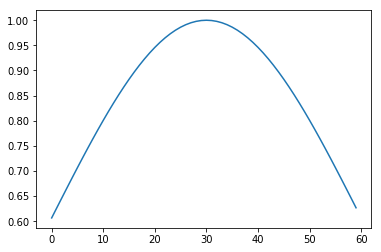

In [9]:
def gaussian_fn(mean, var):
    d = np.sqrt(2*3.142*var**2)
    n = -(mean - np.linspace(0, window*2-1, window*2))**2
    return np.exp(n/(2*var**2))/d

gaussian = gaussian_fn(window, window)
gaussian = gaussian/np.max(gaussian)
plt.plot(gaussian)
gaussian = tr.Tensor(gaussian).type(tr.FloatTensor)
# scale the context by distance from center
v = v*gaussian  # can do this because the indices are still in order
# TODO what if we see the same word multiple times
# within the same contex? should additively increase
# the target?

In [10]:
for e in range(epochs):
    for i, pair in enumerate(batch(skip_gram(tokens, window), batch_size)):
        pair = words, context
        ### pick out training word vectors
        # could pick a subset of w to  compare against -- ie negative sampling
        # doesnt seem like there is much to be gained?
        batch_x = vec[words.view(batch_size)].view((batch_size, d))

        ### do a similarity search to the rest of our vectors
        # (batch_size x v_dims) x (v_dims x n_tokens)
        y = tr.matmul(batch_x, tr.transpose(vec, 1, 0))  # shape = [batch_size x n_tokens]

        ### construct targets
        idx = tr.stack([batch_idx.view(-1), context.view(-1)])
        onehots = torch.sparse.FloatTensor(idx, v.view(-1), torch.Size([batch_size,n])).to_dense()
        onehots = Variable(onehots, requires_grad=False)
        # by using ones as the targets we are training the vectors to be orthonormal??

        ### caluclate loss
        loss = tr.matmul(tr.transpose(y, 1, 0), onehots) - I
        loss = tr.abs(loss).sum(dim=1).mean(dim=0)

        ### auto grad and optimise
        loss.backward()
        vec.data -= learning_rates[e] * vec.grad.data

        # print('\r step: {}'.format(i), end='', flush=True)
        print('\r loss: {}'.format(loss.data.numpy()[0]), end='', flush=True)
np.save('/Volumes/ExtraDiskSpace/Documents/testing_word_encodings/wordvectors.npy', 
        vec.data.numpy())

 loss: 8033.40625562555

KeyboardInterrupt: 

* Wait a minute, do I even need to train this? Can I just solve it?
* Can we track the variance of the gradients to estimate whether there are multiple different meanings/contexts to a token?
* Only learning correlations. How can we capture the ordering as well?
    * Should we add a gaussian window over the skip-gram rather than uniform?
    * Position embeddings? Grammar embeddings?
    * Could we use asymetric (ordering matters) relation networks to capture the syntax/dependencies?

What are we really doing? 

Want a way to index each word in a meaningful way. Ie, we want to learn an ordering of the different word indexes (vectors, encodings, ...) so 

Could imagine just trying to shatter all the different vectors, i.e. making them orthogonal. Would require n dimensions. But, we can do better than this by ordering them in meaningful ways.

Why not just use a binary hash of the 4096 tokens? This means we would only have 12 dimensions in our embeddings!?! 